In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qutip import *

In [12]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister

In [3]:
# Constants

I = np.eye(2)


In [4]:
# "Check" helper functions

def check_trace(rho):
    """
    Check if the trace of the density matrix is 1.
    """
    return np.isclose(rho.tr(), 1.0, atol=1e-10)

def check_hermitian(H):
    """
    Check if the operator is Hermitian.
    """
    return np.allclose(H, H.dag(), atol=1e-10)

def check_unitary(U):
    """
    Check if the operator is unitary.
    """
    return np.allclose(U * U.dag(), I, atol=1e-10) and np.allclose(U.dag() * U, I, atol=1e-10)

def check_psd(mat):
    """
    Check if the matrix is positive semi-definite.
    """
    return np.all(np.linalg.eigvals(mat) >= -1e-10)

def check_choi_decomposition(choi_matrix, pos_choi, neg_choi):
    """
    Check if the Choi matrix is decomposed correctly.
    """
    return np.all(choi_matrix - pos_choi + neg_choi >= -1e-10)


In [5]:
# "Compute" helper functions

def compute_fidelity(rho1, rho2):
    """
    Calculate the fidelity between two density matrices.
    """
    return (rho1 * rho2).tr().sqrt()

def compute_expectation_value(rho, A):
    """
    Calculate the expectation value of an operator A with respect to a density matrix rho.
    """
    return (rho * A).tr()

In [6]:
def construct_choi_matrix(map):

    # TODO: verify if this is the correct way to construct the Choi matrix, currently generated by copilot 


    """
    Construct the Choi matrix for the map
    """
    dim = map.shape[0]
    choi_matrix = np.zeros((dim**2, dim**2), dtype=complex)
    
    for i in range(dim):
        for j in range(dim):
            for k in range(dim):
                for l in range(dim):
                    choi_matrix[i*dim + j, k*dim + l] = map[i, k] * np.conjugate(map[j, l])
    
    return choi_matrix


def positive_and_negative_eigenspaces(choi_matrix):
    """
    Compute the positive and negative eigenspaces of the Choi matrix
    """
    eigenvalues, eigenvectors = np.linalg.eig(choi_matrix)
    
    # Positive eigenspace
    pos_eigenvalues = eigenvalues[eigenvalues > 0]
    pos_eigenvectors = eigenvectors[:, eigenvalues > 0]
    
    # Negative eigenspace
    neg_eigenvalues = eigenvalues[eigenvalues < 0]
    neg_eigenvectors = eigenvectors[:, eigenvalues < 0]
    
    return pos_eigenvalues, pos_eigenvectors, neg_eigenvalues, neg_eigenvectors


def construct_CP_map_from_eigenspace(eigenvalues, eigenvectors):
    """
    Construct the map from the positive and negative eigenspaces
    """
    dim = eigenvectors.shape[0]
    CP_map = np.zeros((dim, dim), dtype=complex)
    
    for i in range(len(eigenvalues)):
        CP_map += eigenvalues[i] * np.outer(eigenvectors[:, i], eigenvectors[:, i].conjugate())
    
    return CP_map


def decompose_into_extremal_CP_maps(choi_matrix_cp_map):

    U23 = np.array([[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]])

    choi_matrix_cp_map_adjoint = U23 @ choi_matrix_cp_map @ U23

    # MIGHT BE JUST PARTIAL TRANSPOSE

    A = choi_matrix_cp_map_adjoint[:2, :2]
    C = choi_matrix_cp_map_adjoint[:2, 2:]
    C_dag = choi_matrix_cp_map_adjoint[2:, :2]
    B = choi_matrix_cp_map_adjoint[2:, 2:]

    assert C.conjugate().T == C_dag, "C and C_dag are not conjugate transpose"
    assert np.allclose(B, I - A, atol=1e-7), "B is not equal to I - A"

    R = np.linalg.inv(np.sqrt(A)) @ C @ np.linalg.inv(np.sqrt(B))

    V, S, W_dag = np.linalg.svd(R)

    theta1 = np.arccos(S[0, 0])
    theta2 = np.arccos(S[1, 1])

    U1_diag = np.diag([np.exp(1j * theta1), np.exp(1j * theta2)])
    U2_diag = np.diag([np.exp(-1j * theta1), np.exp(-1j * theta2)])

    U1 = (1/2)*(V @ U1_diag @ W_dag)
    U2 = (1/2)*(V @ U2_diag @ W_dag) 

    assert check_unitary(U1), "U1 is not unitary"
    assert check_unitary(U2), "U2 is not unitary"

    sqrt_A = np.sqrt(A)
    sqrt_I_A = np.sqrt(B)

    C1 = np.array([[A, sqrt_A @ U1 @ sqrt_I_A], [sqrt_I_A @ U1.conjugate().T @ sqrt_A, B]])
    C2 = np.array([[A, sqrt_A @ U2 @ sqrt_I_A], [sqrt_I_A @ U2.conjugate().T @ sqrt_A, B]])
    
    return C1, C2


def choi_to_map_in_kraus_rep(choi_matrix):
    """
    Convert a Choi matrix to Kraus operators.
    """
    dim = int(np.sqrt(choi_matrix.shape[0]))
    eigenvalues, eigenvectors = np.linalg.eigh(choi_matrix)
    kraus_operators = []

    for i, eigenvalue in enumerate(eigenvalues):
        if eigenvalue > 1e-10:  # Consider only positive eigenvalues
            vector = eigenvectors[:, i]
            psi = vector.reshape((dim, dim), order="F")
            K = np.sqrt(eigenvalue) * K.T
            kraus_operators.append(K)
    
    return kraus_operators

In [7]:
# Simulating one extremal CP map

def compute_rho_prime(kraus_operators, rho):
    """
    Compute the output density matrix from the input density matrix and the Kraus operators.
    """
    rho_prime = np.zeros_like(rho)
    
    for K in kraus_operators:
        rho_prime += K @ rho @ K.conjugate().T
    
    return rho_prime

def T_matrix(kraus_operators):
    """
    Construct the T matrix from the map.
    """
    sigma_vec = [I, sigmax().full(), sigmay().full(), sigmaz().full()]
    dim = kraus_operators[0].shape[0]
    T = np.zeros((dim**2, dim**2), dtype=complex)

    for i in range(dim**2):
        for j in range(dim**2):
            T[i, j] = (1/2)*np.trace(sigma_vec[i] @ compute_rho_prime(kraus_operators, sigma_vec[j]))
    
    distortion_matrix = np.zeros((3, 3), dtype=np.real)
    for i in range(3):
        for j in range(3):
            distortion_matrix[i, j] = T[i+1, j+1]
    distortion_matrix = np.real(distortion_matrix)
    
    shift_vector = T[:, 0][1:].reshape((3, 1))
    
    return T, distortion_matrix, shift_vector

def compute_unitary_and_angles(distortion_matrix, shift_vector):

    U, T_prime, V_T = np.linalg.svd(distortion_matrix, full_matrices=False)

    det_U = np.linalg.det(U)
    det_V = np.linalg.det(V_T)

    U = U / det_U
    V_T = V_T / det_V
    T_prime = T_prime / (det_U * det_V)

    assert check_unitary(U), "U is not unitary"
    assert check_unitary(V_T), "V_T is not unitary"

    T_prime = np.real(np.diag(T_prime))

    nu = np.arccos(T_prime[0])
    mu = np.arccos(T_prime[1])

    assert np.isclose(T_prime[2], np.cos(nu)*np.cos(mu), atol=1e-10), "T_prime[2] is not equal to cos(nu)*cos(mu)"

    t_prime = V_T @ shift_vector

    assert np.isclose(t_prime[0], 0, atol=1e-10), "t_prime[0] is not equal to 0"
    assert np.isclose(t_prime[1], 0, atol=1e-10), "t_prime[1] is not equal to 0"
    assert np.isclose(t_prime[2], np.sin(mu)*np.sin(nu), atol=1e-10), "t_prime[2] is not equal to sin(mu)*sin(nu)"

    return U, V_T.T, mu, nu

In [ ]:
# Build circuit

def build_circuit(U, V, mu, nu, initial_state = "0"):
    """
    Build the circuit from the unitary and angles
    """
    alpha = (1/2)*(mu + nu)
    beta = (1/2)*(mu - nu)

    gamma_1 = (1/2)*(beta - alpha + np.pi/2)
    gamma_2 = (1/2)*(beta + alpha - np.pi/2)

    qubits = QuantumRegister(2, "q")
    cbits = ClassicalRegister(2, "c")
    circuit = QuantumCircuit(qubits, cbits)

    (data, ancilla) = qubits
    (c0, c1) = cbits

    # initial state
    if initial_state == "1":
        circuit.x(data)
    elif initial_state == "+":
        circuit.h(data)
    elif initial_state == "-":
        circuit.x(data)
        circuit.h(data)

    circuit.unitary(V, [data], label="V")
    circuit.ry(2*gamma_1, ancilla)
    circuit.cx(data, ancilla)
    circuit.ry(2*gamma_2, ancilla)

    circuit.measure(ancilla, c1)

    with circuit.if_test((c1, 1)):
        circuit.x(data)
    
    circuit.unitary(U, [data], label="U")

    circuit.measure(data, c0)
    
    return circuit

In [ ]:
# Lindbladian to General Dynamical Map

def get_liouvillian_superoperator(H, l_ops):

    # TODO: verify if this is the correct way to construct the Liouvillian superoperator, currently generated by copilot 


    """
    Get the Liouvillian superoperator from the Hamiltonian and Lindblad operators.
    """
    # Construct the Liouvillian superoperator
    L = -1j * (tensor(H, qeye(2)) - tensor(qeye(2), H)).tr()
    
    for l_op in l_ops:
        L += (tensor(l_op.dag(), qeye(2)) @ tensor(qeye(2), l_op) - 0.5 * (tensor(l_op.dag() * l_op, qeye(2)) + tensor(qeye(2), l_op.dag() * l_op))).tr()
    
    return L


def get_dynamical_map(L, dt):
    """
    Get the dynamical map from the Liouvillian superoperator for time dt.
    """
    # Time evolution operator
    U = (-1j * L * dt).expm()  
    
    return U



# Testing

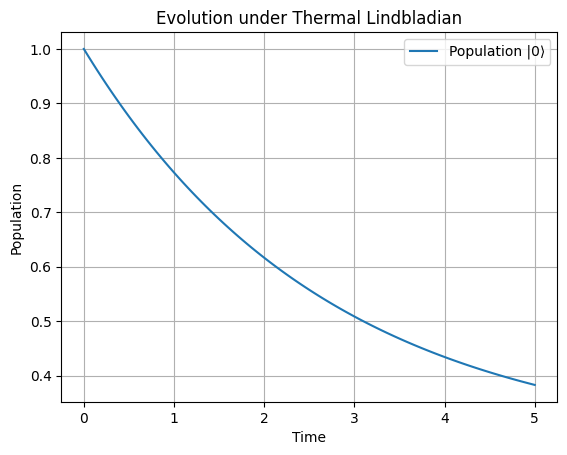

In [ ]:
import numpy as np
from qutip import *

def evolve_rho_over_time(omega, gamma, beta, dt, steps):
    """
    Evolves the initial density matrix under the Lindbladian dynamics over time.

    Parameters:
        omega (float): Qubit frequency
        gamma (float): Base decay rate
        beta (float): Inverse temperature (1/kT)
        dt (float): Time step
        steps (int): Number of time steps

    Returns:
        list of Qobj: List of density matrices over time
    """
    # Pauli operators
    sz = sigmaz()
    sm = sigmam()
    sp = sigmap()

    # Hamiltonian
    H = 0.5 * omega * sz

    # Jump operators
    L1 = np.sqrt(gamma * np.exp(beta * omega)) * sm  # excitation
    L2 = np.sqrt(gamma) * sp                         # relaxation

    # Liouvillian
    L = liouvillian(H, [L1, L2])

    # Initial state: |0><0|
    rho0 = basis(2, 0) * basis(2, 0).dag()
    # rho0 = basis(2, 1) * basis(2, 1).dag()
    rho_t = rho0
    rho_list = [rho0]

    # Time evolution
    for _ in range(steps):
        # Use matrix exponential for superoperator evolution: ρ(t+dt) = exp(L * dt) * ρ(t)
        U = (L * dt).expm()
        rho_t_vec = operator_to_vector(rho_t)
        rho_t_vec = U * rho_t_vec
        rho_t = vector_to_operator(rho_t_vec)
        rho_list.append(rho_t)

    return rho_list

# Example: simulate for 100 steps of 0.05 time units
evolution = evolve_rho_over_time(omega=1.0, gamma=0.1, beta=1.0, dt=0.05, steps=50)

# Plot population of |0⟩ over time
import matplotlib.pyplot as plt

pop0 = [rho[0, 0].real for rho in evolution]
times = np.linspace(0, 5, len(pop0))

plt.plot(times, pop0, label="Population |0⟩")
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("Evolution under Thermal Lindbladian")
plt.grid(True)
plt.legend()
plt.show()


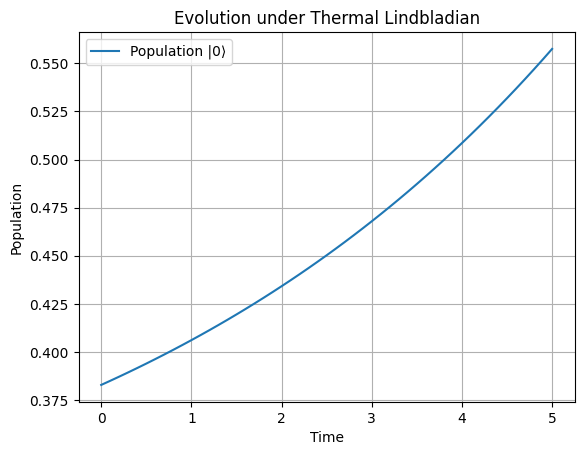

In [26]:
import numpy as np
from qutip import *

def evolve_rho_over_time(omega, gamma, beta, dt, steps):
    """
    Evolves the initial density matrix under the Lindbladian dynamics over time.

    Parameters:
        omega (float): Qubit frequency
        gamma (float): Base decay rate
        beta (float): Inverse temperature (1/kT)
        dt (float): Time step
        steps (int): Number of time steps

    Returns:
        list of Qobj: List of density matrices over time
    """
    # Pauli operators
    sz = sigmaz()
    sm = sigmam()
    sp = sigmap()

    # Hamiltonian
    H = 0.5 * omega * sz

    # Jump operators
    L1 = np.sqrt(gamma * np.exp(beta * omega)) * sm  # excitation
    L2 = np.sqrt(gamma) * sp                         # relaxation

    # Liouvillian
    L = (-1)*liouvillian(H, [L1, L2])

    # Initial state: |0><0|
    rho0 = evolution[-1]
    # rho0 = basis(2, 1) * basis(2, 1).dag()
    rho_t = rho0
    rho_list = [rho0]

    # Time evolution
    for _ in range(steps):
        # Use matrix exponential for superoperator evolution: ρ(t+dt) = exp(L * dt) * ρ(t)
        U = (L * dt).expm()
        rho_t_vec = operator_to_vector(rho_t)
        rho_t_vec = U * rho_t_vec
        rho_t = vector_to_operator(rho_t_vec)
        rho_list.append(rho_t)

    return rho_list

# Example: simulate for 100 steps of 0.05 time units
evolution = evolve_rho_over_time(omega=1.0, gamma=0.1, beta=1.0, dt=0.05, steps=50)

# Plot population of |0⟩ over time
import matplotlib.pyplot as plt

pop0 = [rho[0, 0].real for rho in evolution]
times = np.linspace(0, 5, len(pop0))

plt.plot(times, pop0, label="Population |0⟩")
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("Evolution under Thermal Lindbladian")
plt.grid(True)
plt.legend()
plt.show()
